Iñigo Martin Melero

## Participante 11

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_11_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0      5.0     10
1           50      5.0      5.0     10
2          100      5.0      5.0     10
3          150      5.0      5.0     10
4          200      5.0      5.0     10
...        ...      ...      ...    ...
49027  2451350      5.0      5.0     12
49028  2451400      5.0      5.0     12
49029  2451450      5.0      5.0     12
49030  2451500      5.0      5.0     12
49031  2451550      5.0      5.0     12

[49032 rows x 4 columns]


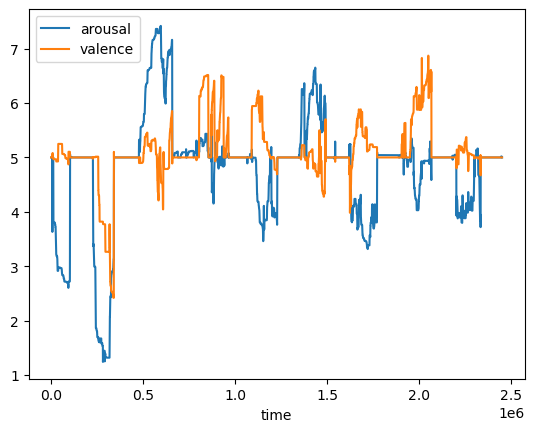

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_11_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.843  38.898  28.741  32.227  30.038     9.629     7.534   
1              1  0.839  38.995  28.812  32.208  30.041     9.588     7.534   
2              2  0.849  39.053  28.727  32.208  30.035     9.588     7.453   
3              3  0.853  38.536  28.726  32.227  30.041     9.547     7.534   
4              4  0.866  38.665  28.726  32.227  30.045     9.588     7.616   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.810  35.973  17.368  37.299  33.747     8.397     6.303   
2451580  2451580  0.826  36.070  17.395  37.290  33.733     8.356     6.302   
2451581  2451581  0.849  35.840  17.336  37.328  33.754     8.478     6.343   
2451582  2451582  0.836  35.944  17.336  37.309  33.747     8.438     6.384   
2451583  2451583  0.843  36.050  17.386  37.271  33.740     8.357     6.141   

         emg_trap  video  
0           7.986     10

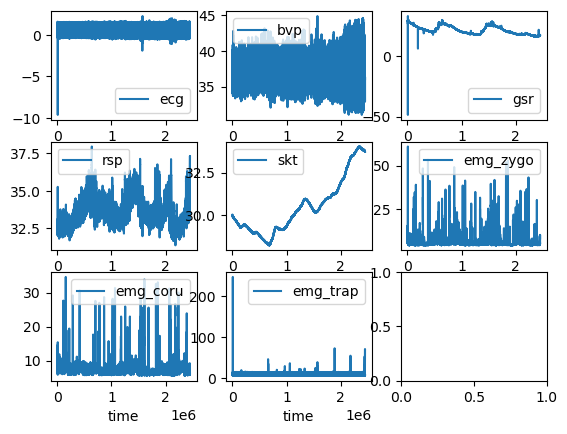

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

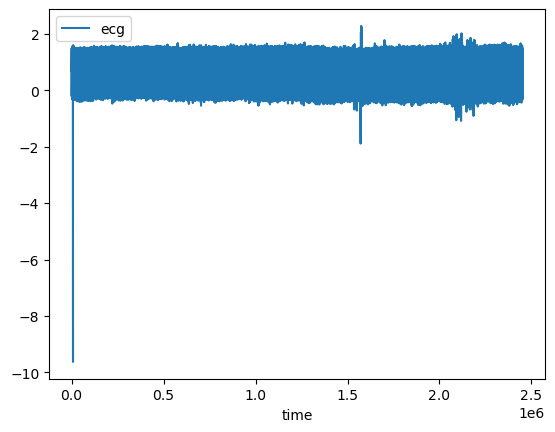

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

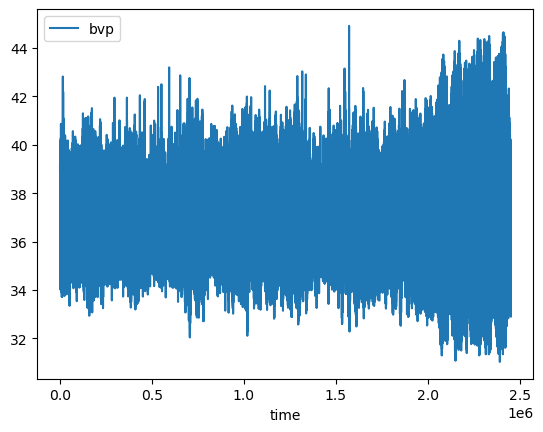

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

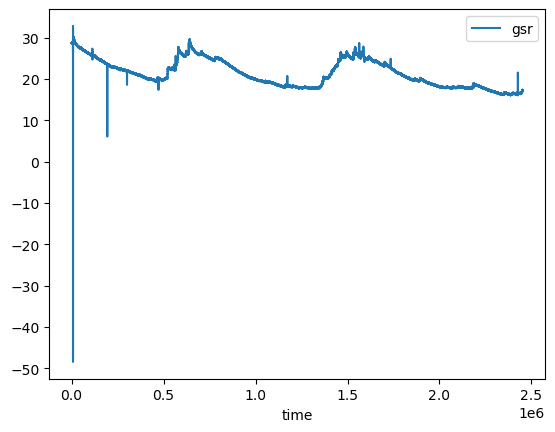

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

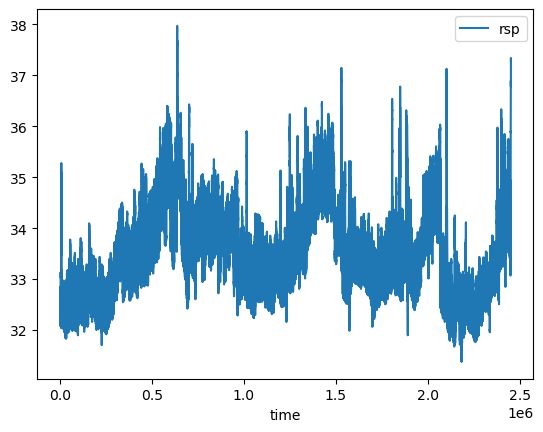

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

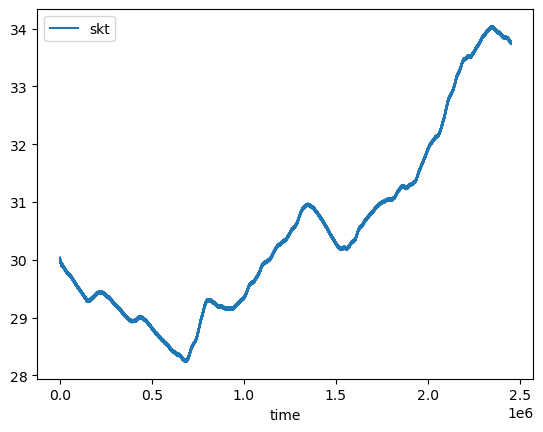

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

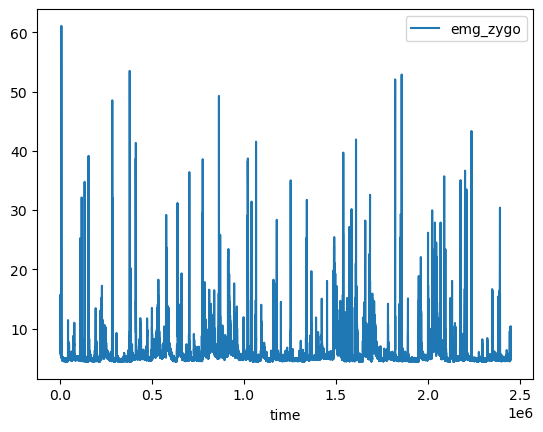

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

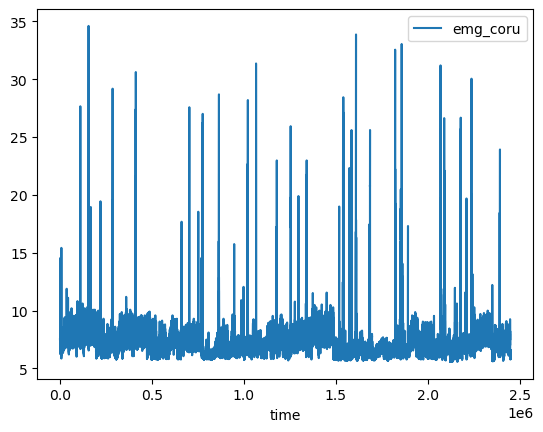

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

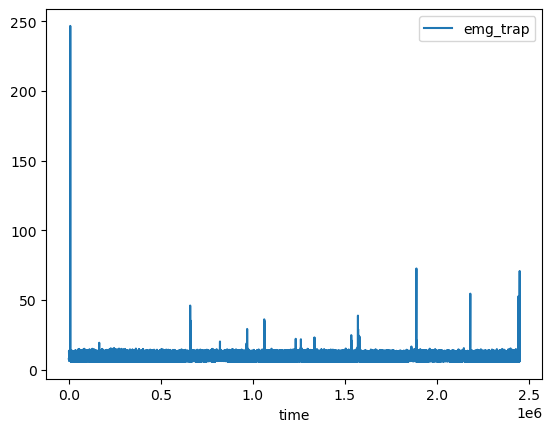

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

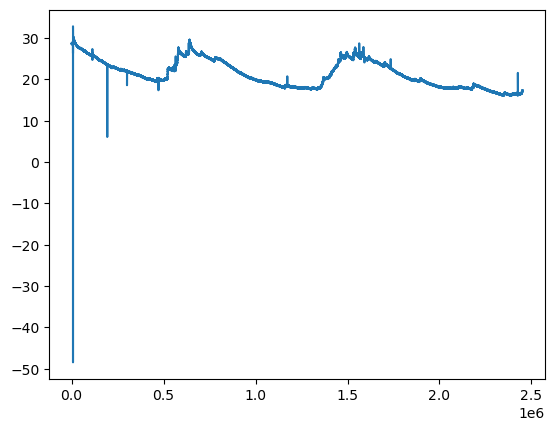

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

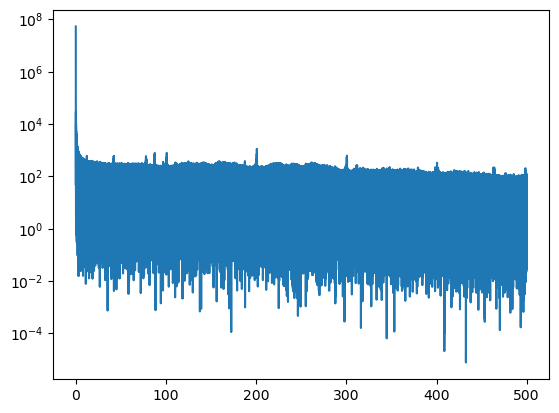

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

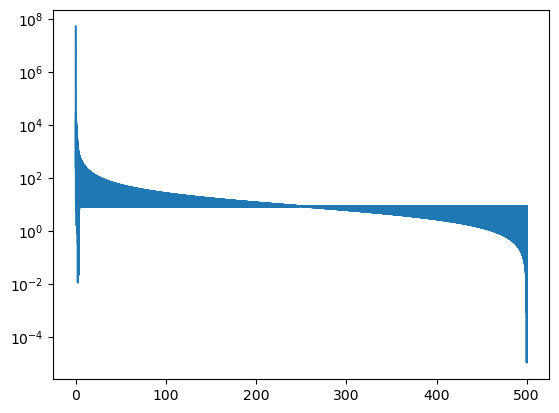

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

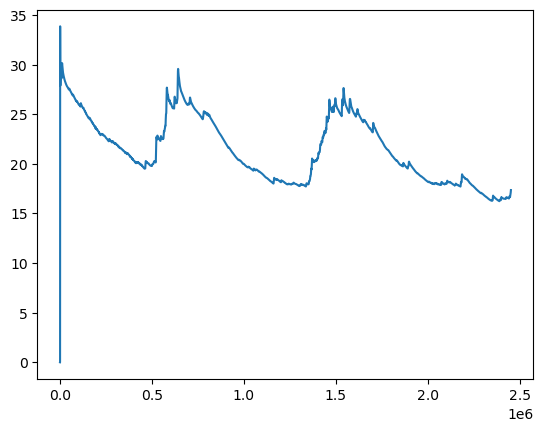

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  17.354
2451580  17.355
2451581  17.355
2451582  17.355
2451583  17.355

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

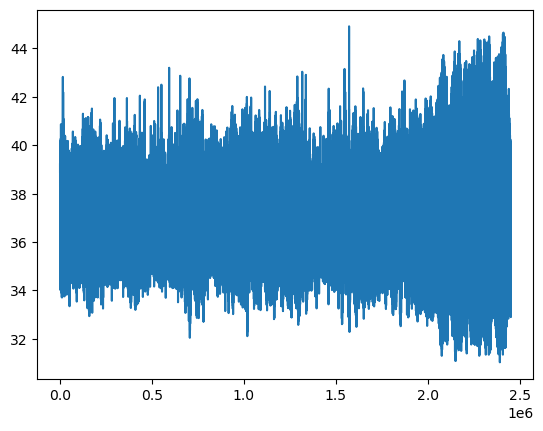

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

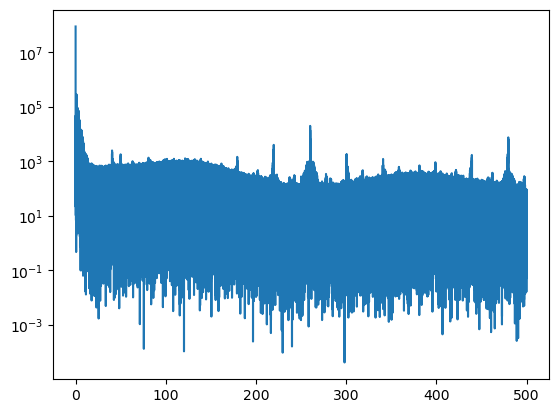

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

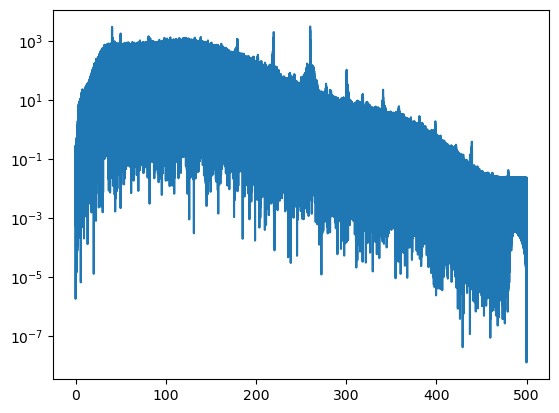

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

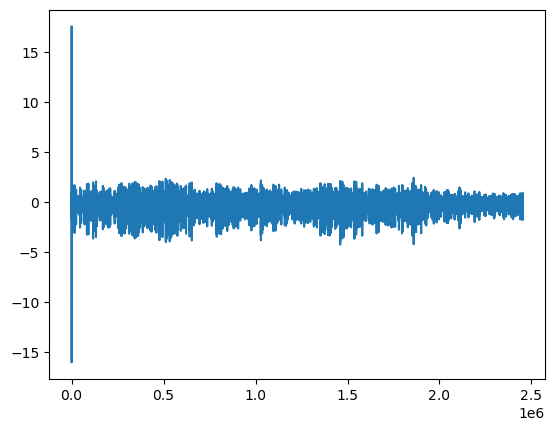

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.081
1        43.032
2        51.203
3        54.571
4        46.800
...         ...
2451579  36.817
2451580  36.865
2451581  36.967
2451582  37.052
2451583  37.061

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

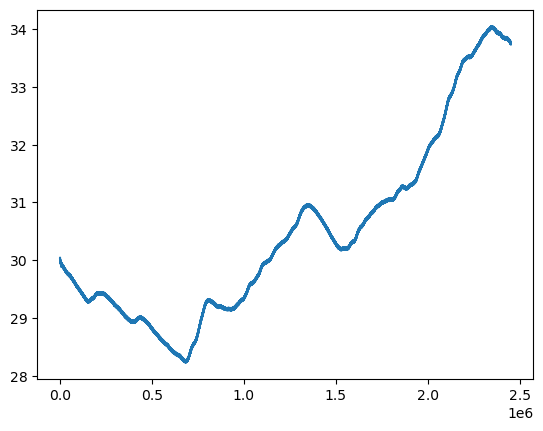

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

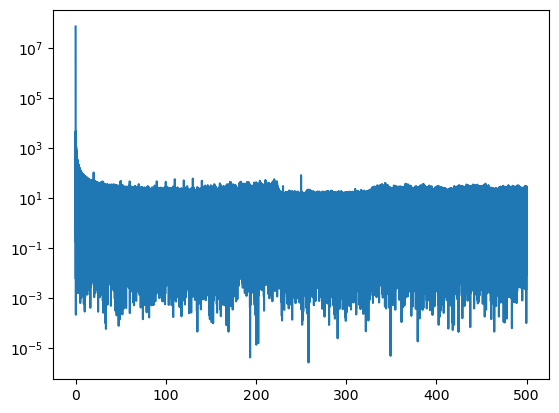

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

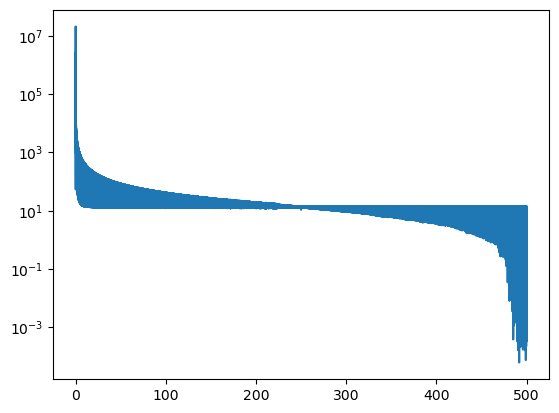

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

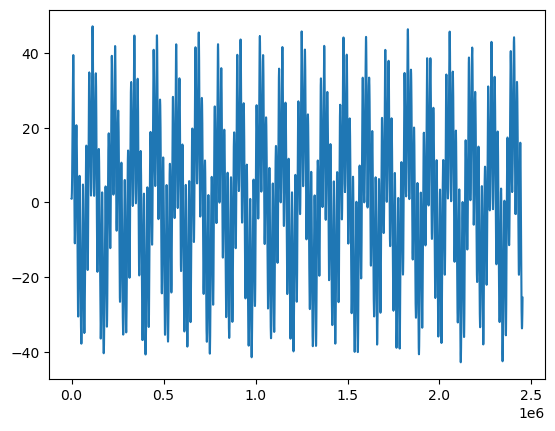

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.963
1        40.963
2        40.963
3        40.963
4        40.963
...         ...
2451579  14.434
2451580  14.438
2451581  14.444
2451582  14.448
2451583  14.453

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.843  32.227     9.629     7.534     7.986     10
1              1  0.839  32.208     9.588     7.534     8.027     10
2              2  0.849  32.208     9.588     7.453     8.109     10
3              3  0.853  32.227     9.547     7.534     8.028     10
4              4  0.866  32.227     9.588     7.616     8.109     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.810  37.299     8.397     6.303     6.713     12
2451580  2451580  0.826  37.290     8.356     6.302     6.632     12
2451581  2451581  0.849  37.328     8.478     6.343     6.753     12
2451582  2451582  0.836  37.309     8.438     6.384     6.714     12
2451583  2451583  0.843  37.271     8.357     6.141     6.591     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.843  32.227     9.629     7.534     7.986     10  38.081   
1              1  0.839  32.208     9.588     7.534     8.027     10  43.032   
2              2  0.849  32.208     9.588     7.453     8.109     10  51.203   
3              3  0.853  32.227     9.547     7.534     8.028     10  54.571   
4              4  0.866  32.227     9.588     7.616     8.109     10  46.800   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.810  37.299     8.397     6.303     6.713     12  36.817   
2451580  2451580  0.826  37.290     8.356     6.302     6.632     12  36.865   
2451581  2451581  0.849  37.328     8.478     6.343     6.753     12  36.967   
2451582  2451582  0.836  37.309     8.438     6.384     6.714     12  37.052   
2451583  2451583  0.843  37.271     8.357     6.141     6.591     12  37.061   

            gsr     skt  
0         0.000  40.963  
1         0.000  40.963  
2         0.000  40.963  
3         0.000  40.963  
4         0.000  40.963  
...         ...     ...  
2451579  17.354  14.434  
2451580  17.355  14.438  
2451581  17.355  14.444  
2451582  17.355  14.448  
2451583  17.355  14.453  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.838901  0.649181  0.495617  0.780698  0.179364  0.021009   
221502    221502  0.840015  0.650546  0.495617  0.780628  0.176170  0.022814   
221503    221503  0.831849  0.653730  0.495617  0.780546  0.179205  0.021032   
221504    221504  0.835189  0.655700  0.495617  0.780476  0.183836  0.023727   
221505    221505  0.826652  0.649939  0.495617  0.780395  0.180802  0.021945   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.643653  0.648727  0.000000  0.343996  0.177767  0.010026   
2331580  2331580  0.643653  0.650091  0.000000  0.344077  0.176170  0.010939   
2331581  2331581  0.648478  0.649636  0.000000  0.344171  0.177767  0.010939   
2331582  2331582  0.645137  0.651152  0.000000  0.344252  0.182239  0.011853   
2331583  2331583  0.637713  0.655852  0.000000  0.344322  0.171698  0.008243   

         emg_coru  emg_trap  video  
221501   0.077327  0.095046      3  
221502   0.075687  0.089520      3  
221503   0.077327  0.089451      3  
221504   0.080689  0.092249      3  
221505   0.077368  0.086722      3  
...           ...       ...    ...  
2331579  0.102665  0.039097      6  
2331580  0.100943  0.030704      6  
2331581  0.102583  0.041758      6  
2331582  0.102583  0.041826      6  
2331583  0.099262  0.036299      6  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.838901  0.649181  0.495617  0.179364  0.780698  0.021009   
221502    221502  0.840015  0.650546  0.495617  0.176170  0.780628  0.022814   
221503    221503  0.831849  0.653730  0.495617  0.179205  0.780546  0.021032   
221504    221504  0.835189  0.655700  0.495617  0.183836  0.780476  0.023727   
221505    221505  0.826652  0.649939  0.495617  0.180802  0.780395  0.021945   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.643653  0.648727  0.000000  0.177767  0.343996  0.010026   
2331580  2331580  0.643653  0.650091  0.000000  0.176170  0.344077  0.010939   
2331581  2331581  0.648478  0.649636  0.000000  0.177767  0.344171  0.010939   
2331582  2331582  0.645137  0.651152  0.000000  0.182239  0.344252  0.011853   
2331583  2331583  0.637713  0.655852  0.000000  0.171698  0.344322  0.008243   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
221540   0.766889  0.651910  0.495617  0.172976  0.777712  0.021900  0.067241   
221560   0.690052  0.639782  0.495617  0.169941  0.776172  0.019182  0.078967   
221580   0.636600  0.652668  0.495617  0.165309  0.774620  0.019182  0.119475   
221600   0.615813  0.651001  0.495617  0.159240  0.773080  0.019182  0.109307   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.848552  0.662674  0.000076  0.176010  0.337440  0.012744  0.073965   
2331520  0.815887  0.639024  0.000000  0.173135  0.339096  0.010939  0.080689   
2331540  0.751299  0.640995  0.000000  0.173135  0.340764  0.012766  0.117753   
2331560  0.694878  0.656913  0.000000  0.176170  0.342421  0.013657  0.109348   
2331580  0.643653  0.650091  0.000000  0.176170  0.344077  0.010939  0.100943   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1      0.766889  0.651910  0.495617  0.172976  0.777712  0.021900  0.067241   
2      0.690052  0.639782  0.495617  0.169941  0.776172  0.019182  0.078967   
3      0.636600  0.652668  0.495617  0.165309  0.774620  0.019182  0.119475   
4      0.615813  0.651001  0.495617  0.159240  0.773080  0.019182  0.109307   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.848552  0.662674  0.000076  0.176010  0.337440  0.012744  0.073965   
63500  0.815887  0.639024  0.000000  0.173135  0.339096  0.010939  0.080689   
63501  0.751299  0.640995  0.000000  0.173135  0.340764  0.012766  0.117753   
63502  0.694878  0.656913  0.000000  0.176170  0.342421  0.013657  0.109348   
63503  0.643653  0.650091  0.000000  0.176170  0.344077  0.010939  0.100943   

       emg_trap  valence  arousal  
0      0.078261    5.000    5.000  
1      0.067072    5.000    5.000  
2      0.064274    5.000    5.000  
3      0.064206    5.000    5.000  
4      0.067072    5.000    5.000  
...         ...      ...      ...  
63499  0.064138    5.022    3.957  
63500  0.050287    5.022    3.953  
63501  0.052948    5.022    3.946  
63502  0.044555    5.022    3.938  
63503  0.030704    5.022    3.930  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1      0.766889  0.651910  0.495617  0.172976  0.777712  0.021900  0.067241   
2      0.690052  0.639782  0.495617  0.169941  0.776172  0.019182  0.078967   
3      0.636600  0.652668  0.495617  0.165309  0.774620  0.019182  0.119475   
4      0.615813  0.651001  0.495617  0.159240  0.773080  0.019182  0.109307   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.731626  0.627805  0.000152  0.159240  0.330767  0.012788  0.067323   
63496  0.762064  0.618405  0.000152  0.162274  0.332435  0.010048  0.055474   
63497  0.805865  0.646149  0.000076  0.165309  0.334103  0.010026  0.063879   
63498  0.832962  0.652820  0.000076  0.162274  0.335771  0.006416  0.057196   
63499  0.848552  0.662674  0.000076  0.176010  0.337440  0.012744  0.073965   

       emg_trap  valence  arousal  
0      0.078261    5.000    5.000  
1      0.067072    5.000    5.000  
2      0.064274    5.000    5.000  
3      0.064206    5.000    5.000  
4      0.067072    5.000    5.000  
...         ...      ...      ...  
63495  0.097980    5.022    3.968  
63496  0.072735    5.022    3.966  
63497  0.069937    5.022    3.963  
63498  0.067140    5.022    3.960  
63499  0.064138    5.022    3.957  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
 1   0.766889  0.651910  0.495617  0.172976  0.777712  0.021900  0.067241   
 2   0.690052  0.639782  0.495617  0.169941  0.776172  0.019182  0.078967   
 3   0.636600  0.652668  0.495617  0.165309  0.774620  0.019182  0.119475   
 4   0.615813  0.651001  0.495617  0.159240  0.773080  0.019182  0.109307   
 5   0.603563  0.640085  0.495617  0.156045  0.771529  0.016487  0.084133   
 6   0.609503  0.649030  0.495617  0.153011  0.769977  0.017355  0.065560   
 7   0.612101  0.638266  0.495617  0.156045  0.768426  0.018247  0.079008   
 8   0.614699  0.648878  0.495617  0.149816  0.766874  0.017311  0.078926   
 9   0.618040  0.651152  0.495541  0.135921  0.765311  0.015506  0.084010   
 10  0.618040  0.652517  0.495541  0.131289  0.763760  0.017333  0.094137   
 11  0.620638  0.639175  0.495541  0.122025  0.762196  0.016442  0.085773   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       193       194       195  \
0     0.078261  0.766889  0.651910  ...  0.657016  0.647968  0.495465   
1     0.053152  0.670750  0.647514  ...  0.623237  0.652213  0.495617   
2     0.053016  0.621752  0.645391  ...  0.586488  0.644178  0.495846   
3     0.047421  0.916852  0.661765  ...  0.618040  0.631292  0.497751   
4     0.069801  0.607275  0.650091  ...  0.724202  0.656004  0.499352   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.027975  0.624350  0.653123  ...  0.639941  0.659036  0.002592   
2536  0.268832  0.685226  0.647968  ...  0.609503  0.632505  0.001906   
2537  0.047421  0.610616  0.660249  ...  0.726800  0.656004  0.001448   
2538  0.089520  0.799926  0.649939  ...  0.612101  0.662371  0.000686   
2539  0.055813  0.614328  0.639327  ...  0.848552  0.662674  0.000076   

           196       197       198       199       200  valence  arousal  
0     0.084970  0.741805  0.018247  0.072325  0.061613  5.00000  5.00000  
1     0.064846  0.702562  0.020074  0.057155  0.050287  5.00000  5.00000  
2     0.153011  0.664345  0.018247  0.080689  0.041826  5.00000  5.00000  
3     0.237981  0.628310  0.016420  0.077327  0.064274  5.00000  5.00000  
4     0.168503  0.595378  0.016464  0.063920  0.095183  5.00000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.139115  0.181412  0.010048  0.074047  0.437022  5.00188  4.47296  
2536  0.122025  0.216199  0.013657  0.126117  0.058543  5.00904  4.33468  
2537  0.115796  0.254730  0.013679  0.151415  0.117426  5.01300  4.17344  
2538  0.111324  0.295665  0.010939  0.079090  0.058611  5.01740  4.07972  
2539  0.176010  0.337440  0.012744  0.073965  0.064138  5.02200  3.99476  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub11.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub11.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub11.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub11.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.824425  0.640237  0.495617  0.177607  0.779252  0.022814  0.078967   
1     0.668151  0.649636  0.495465  0.084970  0.740230  0.018269  0.063879   
2     0.624350  0.631747  0.495617  0.066443  0.700999  0.018247  0.057155   
3     0.726429  0.637962  0.495846  0.160677  0.662852  0.017355  0.067241   
4     0.614699  0.636295  0.497828  0.239578  0.626934  0.019160  0.070644   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.630290  0.644027  0.002973  0.177767  0.152551  0.013702  0.111111   
2536  0.668151  0.657368  0.002592  0.143747  0.182719  0.013657  0.094137   
2537  0.612101  0.642207  0.001906  0.123622  0.217669  0.011853  0.104264   
2538  0.756125  0.661765  0.001372  0.108130  0.256329  0.010048  0.134604   
2539  0.610987  0.638569  0.000762  0.115796  0.297333  0.010939  0.079008   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub11.csv', index=False)